In [43]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

TODO:
Run multiple seeds with multiple values of readout (ra) and feature (fa)

Dans le yaml:
   feature_rotation:
      rotation_magnitude:             0 # TODO here is feature
    readout_rotation:
      rotation_magnitude:             1.5 # 3.14159   # TODO here is readout


0 <-> 0
1 <-> 3.14

In [44]:
wanted_path= "../../cata/run/results/TEXT_EXP2"

In [45]:
RESULTS_PATH = wanted_path
SEEDS = range(2) # to adapt

In [ ]:
# data_logger can be changed into data_logger_network no pb

def get_organised_paths(results_path, seeds):
    timestamps = os.listdir(results_path)
    data_logger_paths = {s: {} for s in seeds}
    
    for timestamp in timestamps:
        timestamp_experiments = os.listdir(os.path.join(results_path, timestamp))
        for exp in timestamp_experiments:
            split_name = exp.split("_")
            seed = int(split_name[1][1:])
            ra = float(split_name[2][2:])
            fa = float(split_name[3][2:])
            # data_logger_paths[seed][(fa, ra)] = os.path.join(results_path, timestamp, exp, str(seed), "data_logger.csv")
            data_logger_paths[seed][(fa, ra)] = os.path.join(results_path, timestamp, exp, "data_logger.csv")
        
    return data_logger_paths

In [47]:
organised_paths = get_organised_paths(RESULTS_PATH, SEEDS)

In [48]:
organised_paths

{0: {(0.5,
   1.0): '../../cata/run/results/TEXT_EXP2\\2025-02-12-06-37-04\\single_s0_ra1_fa0.5\\data_logger.csv',
  (1.0,
   1.0): '../../cata/run/results/TEXT_EXP2\\2025-02-12-06-37-04\\single_s0_ra1_fa1\\data_logger.csv'},
 1: {(0.7,
   1.0): '../../cata/run/results/TEXT_EXP2\\2025-02-12-06-37-04\\single_s1_ra1_fa0.7\\data_logger.csv',
  (1.0,
   1.0): '../../cata/run/results/TEXT_EXP2\\2025-02-12-06-37-04\\single_s1_ra1_fa1\\data_logger.csv'}}

In [49]:
# import tempfile

# def test_get_organised_paths(wanted_path):

#     # with tempfile.TemporaryDirectory() as tmpdirname:
#     # create dummmy file structure
#     test_dates = ["2025-02-10-17-41-15", "2025-02-12-06-37-04"]
#     test_exp_names = {1: "exp_s1_ra0.2_fa0.1", 2: "exp_s2_ra0.2_fa0.8"}
#     for test_date in test_dates:
#         os.mkdir(os.path.join(wanted_path, test_date))
#         for seed, test_exp in test_exp_names.items():
#             # print(os.path.join(tmpdirname, test_date, test_exp, str(seed)))
#             # os.mkdir(os.path.join(tmpdirname, test_date, test_exp))
#             # os.mkdir(os.path.join(tmpdirname, test_date, test_exp, str(seed)))
#             # open(os.path.join(tmpdirname, test_date, test_exp, str(seed), "data_logger.csv"), 'a').close()
#             print(os.path.join(wanted_path, test_date, test_exp, str(seed)))
#             os.mkdir(os.path.join(wanted_path, test_date, test_exp))
#             os.mkdir(os.path.join(wanted_path, test_date, test_exp, str(seed)))
#             open(os.path.join(wanted_path, test_date, test_exp, str(seed), "data_logger.csv"), 'a').close()

#     test_data_logger_paths = get_organised_paths(wanted_path, range(3))

#     return test_data_logger_paths

In [50]:
# test_get_organised_paths(wanted_path)
list(organised_paths.values())[1]

{(0.7,
  1.0): '../../cata/run/results/TEXT_EXP2\\2025-02-12-06-37-04\\single_s1_ra1_fa0.7\\data_logger.csv',
 (1.0,
  1.0): '../../cata/run/results/TEXT_EXP2\\2025-02-12-06-37-04\\single_s1_ra1_fa1\\data_logger.csv'}

In [57]:
def get_metrics(df_paths, switch_step, final_step, threshold=None, second_task_cutoff=None):
    dfs = {k: pd.read_csv(df_path) for k, df_path in df_paths.items()}
    if switch_step is None:
        assert threshold is not None, "No switch step given, must give threshold instead."
        # infer from threshold
        # all first teacher errors should be the same, so take arbitrary one
        sample_df = dfs[list(dfs.keys())[0]]
        sample_df_first_error = np.array(sample_df.log_generalisation_error_0)
        switch_step = np.where(sample_df_first_error < threshold)[0][0] + 1
        if second_task_cutoff is not None:
            final_step = switch_step + second_task_cutoff
        else:
            final_step = len(sample_df)
    switch_errors = {k: df.log_generalisation_error_0[switch_step - 1] for k, df in dfs.items()}
    final_errors = {k: df.log_generalisation_error_0[final_step - 1] for k, df in dfs.items()}
    switch_errors_1 = {k: df.log_generalisation_error_1[switch_step - 1] for k, df in dfs.items()}
    final_errors_1 = {k: df.log_generalisation_error_1[final_step - 1] for k, df in dfs.items()}
    forgetting = {k: df.log_generalisation_error_0[final_step - 1] - df.log_generalisation_error_0[switch_step - 1] for k, df in dfs.items()}
    forgetting_rate = {k: np.mean([df.log_generalisation_error_0[switch_step - 1 + i + 1] - df.log_generalisation_error_0[switch_step - 1 + i] for i in range(10)]) for k, df in dfs.items()}
    max_forgetting = {k: np.amax(df.log_generalisation_error_0[switch_step - 1:final_step]) - df.log_generalisation_error_0[switch_step - 1] for k, df in dfs.items()}

    # print(switch_errors)
    # for k, df in dfs.items():
    #     print(df.log_generalisation_error_1)


    # TODO modify below when enough samples
    # second_threshold_steps = {k: np.where(df.log_generalisation_error_1 < switch_errors[k])[0][0] for k, df in dfs.items()}
    second_threshold_steps = {k: np.where(df.log_generalisation_error_1 < 4)[0][0] for k, df in dfs.items()}
    adjusted_forgetting = {k: df.log_generalisation_error_0[second_threshold_steps[k]] - df.log_generalisation_error_0[switch_step - 1] for k, df in dfs.items()}
    transfer = {k: df.log_generalisation_error_1[switch_step - 1] - df.log_generalisation_error_1[final_step - 1] for k, df in dfs.items()}
    transfer_rate = {k: np.mean([df.log_generalisation_error_1[switch_step - 1 + i] - df.log_generalisation_error_1[switch_step - 1 + i + 1] for i in range(10)]) for k, df in dfs.items()}
    max_transfer = {k: df.log_generalisation_error_1[switch_step - 1] - np.amin(df.log_generalisation_error_1[switch_step - 1:final_step]) for k, df in dfs.items()}
    return forgetting, forgetting_rate, max_forgetting, adjusted_forgetting, transfer, transfer_rate, max_transfer

In [52]:
def get_2d_plot_base(sample_metric):
    x, y = np.meshgrid(np.linspace(0, 1, 11), np.linspace(0, 1, 11))
    unique_sorted_keys = np.unique([i[0] for i in sorted(list(sample_metric.keys()), key=lambda x: float(x[0]))])
    x_overlap_map = {v: i for i, v in enumerate(unique_sorted_keys)}
    y_overlap_map = {v: i for i, v in enumerate(np.unique([i[1] for i in sorted(list(sample_metric.keys()), key=lambda x: float(x[1]))]))}
    return x_overlap_map, y_overlap_map

In [53]:
def get_z(value_dict):
    z = np.zeros((11, 11))
    
    x_overlap_map, y_overlap_map = get_2d_plot_base(value_dict)

    for k, f_value in value_dict.items():
        x_val = k[0]
        y_val = k[1]
        x_index = x_overlap_map[x_val]
        y_index = y_overlap_map[y_val]
        z[x_index][y_index] = f_value
    return z

In [59]:
path_save_figures = "figures/"

def plot2d(metric, metric_title, cmap, save_name):
    fig = plt.figure()
    plt.imshow(get_z(metric), origin="lower", extent=[0, 1, 0, 1], cmap=cmap)
    plt.xlabel("Feature Similarity")
    plt.ylabel("Readout Similarity")
    plt.title(metric_title)
    plt.colorbar()
    fig.show()
    fig.savefig(os.path.join(path_save_figures, save_name), dpi=100)

C:\Users\Lisa_ach\AppData\Local\Temp\ipykernel_18844\2124042288.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\Lisa_ach\AppData\Local\Temp\ipykernel_18844\2124042288.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\Lisa_ach\AppData\Local\Temp\ipykernel_18844\2124042288.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\Lisa_ach\AppData\Local\Temp\ipykernel_18844\2124042288.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\Lisa_ach\AppData\Local\Temp\ipykernel_18844\2124042288.py:10: UserWarning: Matplotlib is cu

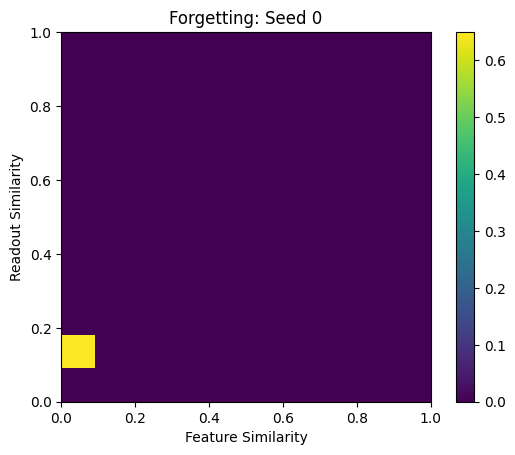

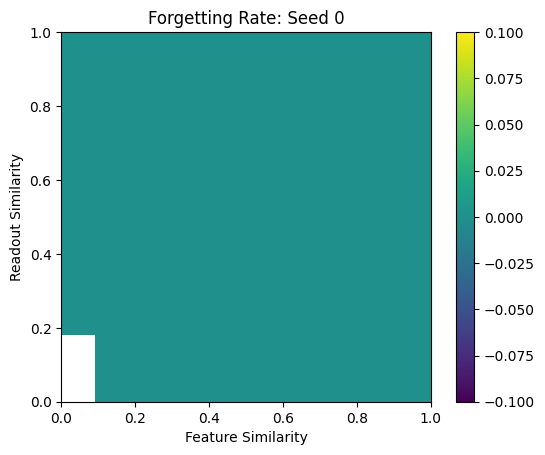

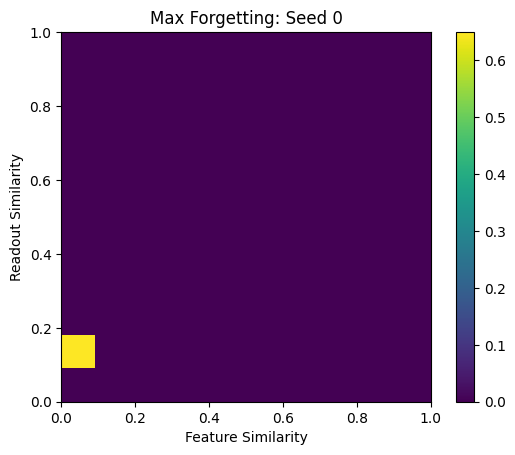

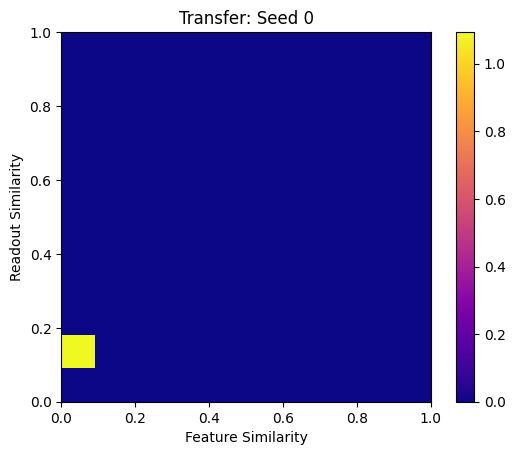

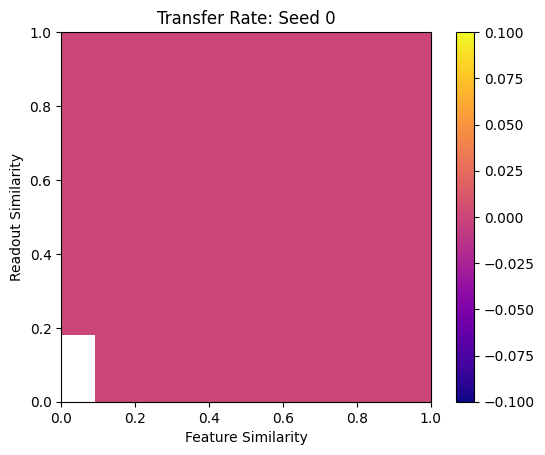

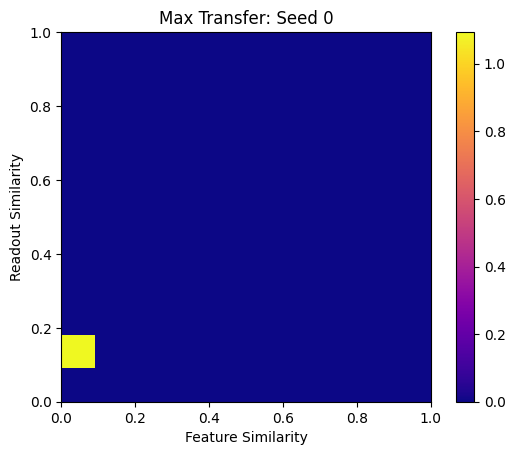

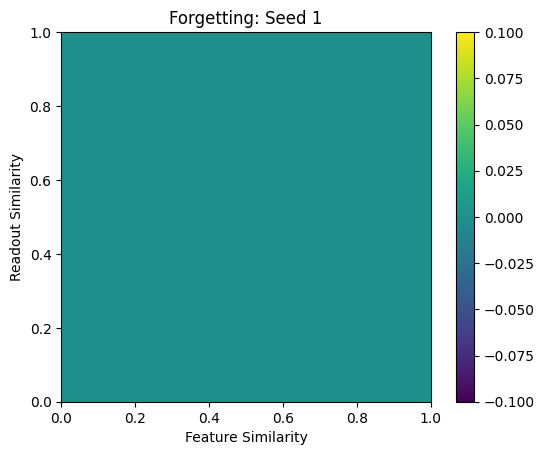

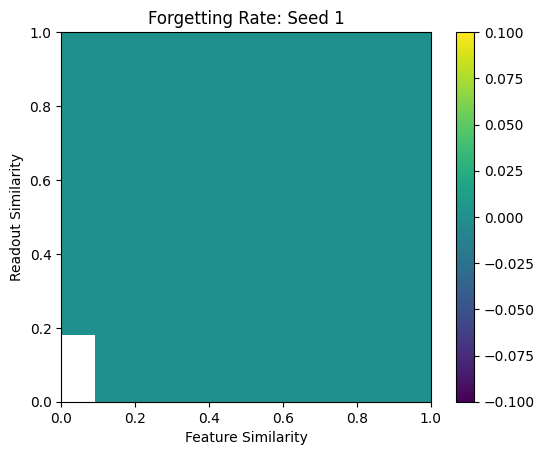

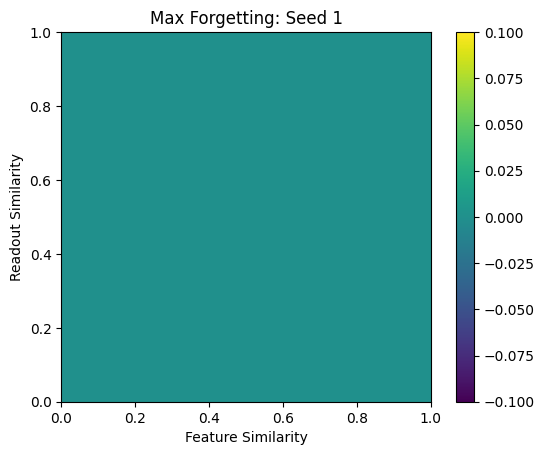

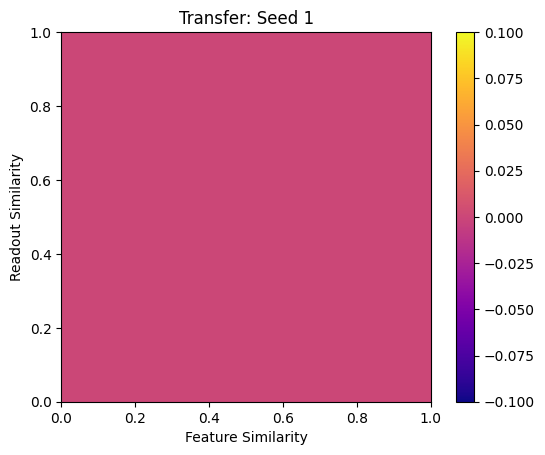

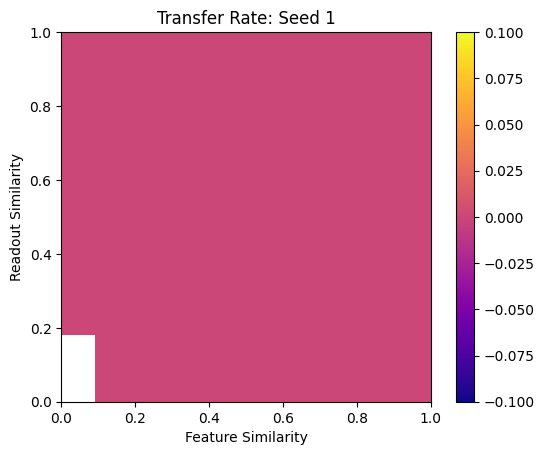

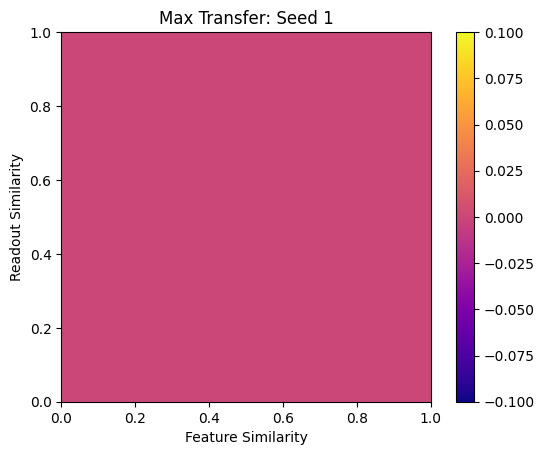

In [60]:
for seed, seed_dfs in organised_paths.items():
    seed_forgetting, seed_forgetting_rate, seed_max_forgetting, seed_adjusted_forgetting, seed_transfer, seed_transfer_rate, seed_max_transfer = get_metrics(df_paths=seed_dfs, switch_step=None, final_step=None, threshold=-4)
    plot2d(seed_forgetting, f"Forgetting: Seed {seed}", "viridis", f"forgetting_seed_{seed}.pdf")
    plot2d(seed_forgetting_rate, f"Forgetting Rate: Seed {seed}", "viridis", f"forgetting_rate_seed_{seed}.pdf")
    plot2d(seed_max_forgetting, f"Max Forgetting: Seed {seed}", "viridis", f"max_forgetting_seed_{seed}.pdf")
    plot2d(seed_transfer, f"Transfer: Seed {seed}", "plasma", f"transfer_seed_{seed}.pdf")
    plot2d(seed_transfer_rate, f"Transfer Rate: Seed {seed}", "plasma", f"transfer_rate_seed_{seed}.pdf")
    plot2d(seed_max_transfer, f"Max Transfer: Seed {seed}", "plasma", f"max_transfer_seed_{seed}.pdf")